#TP4 – DeepLearning&auto-encodeurs

Maxence QUEYRE

Le but de ce TP est de créer une architecture de réseaux de neurones profonds, constituée d'au moins 3 couches.

Chaque couche cachée de ce réseau sera apprise avec un autoencodeur dont sera extraite la couche cachée. Ces couches seront ensuite stackées pour des dimensions en taille décroissante (chaque autoencodeur devra essayer apprendra l'encodage de la couche cachée de l'Autoencodeur précédent).

Nous testerons ensuite l'Architecture sur de la classification bi-classe et multi-classe en utilisant le jeu de données MNIST.

Enfin, nous visualiserons les features apprises en activant les neurones sur les couches cachées de notre réseau.

##Chargement des Données

In [1]:
require 'nn'
require 'image'
mnist = require 'mnist'

trainset = mnist.traindataset()
testset = mnist.testdataset()

print(trainset.size) -- to retrieve the size

60000	


In [3]:
trainset(0)

[string "local f = function() return trainset(0) end; ..."]:1: attempt to call global 'trainset' (a table value)
stack traceback:
	[string "local f = function() return trainset(0) end; ..."]:1: in function 'f'
	[string "local f = function() return trainset(0) end; ..."]:1: in main chunk
	[C]: in function 'xpcall'
	/Users/meat/torch/install/share/lua/5.1/itorch/main.lua:179: in function </Users/meat/torch/install/share/lua/5.1/itorch/main.lua:143>
	/Users/meat/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/Users/meat/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/Users/meat/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/Users/meat/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/Users/meat/torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/meat/Library/Jupyter/runtime/ker..."]:1: in main chunk: 

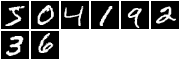

In [2]:
itorch.image({trainset.data[1], trainset.data[2],trainset.data[3], trainset.data[4],trainset.data[5],trainset.data[6],trainset.data[8],trainset.data[14]})

#Utilitaires

###Transformation et sélection des Données

In [3]:
-- Fonctions qui permette de créer nos testset et trainset avec les classes voulues
-- y est une liste !
function getClass(y, set)
   nElem = set.size
   local tempX = torch.zeros(nElem, 28*28)
   local tempy = torch.zeros(nElem,1)
   local cpt = 0
   for i=1, set.size do
       for j=1, #y do
           if set[i]['y']==y[j] then
                cpt=cpt+1
                tempX[cpt]=set.data[i]
                tempy[cpt]=j --set.label[i] -- pour le NLL 
           end
        end
   end
    
   local resX = torch.zeros(cpt, 28*28)
   local resy = torch.zeros(cpt,1) 
   for i=1, cpt do
        resX[i] = tempX[i]
        resy[i] = tempy[i]   
   end
   return (resX/128) - 1, resy
end

function getClassTrainTest(y, trainset, testset)
   local XTrain, yTrain=getClass(y, trainset)
   local XTest, yTest=getClass(y, testset)
   return XTrain, yTrain, XTest, yTest
end

Lors de la récupération des données, on convertir les valeurs des pixels dans l'intervalle [-1;1].
Les autoencodeurs présentés dans la suite utiliseront la fonction d'activation tangente hyperbolique qui permettra de reconstruire des données dans cet intervalle.

###Création des autoencodeurs

In [4]:
-- modules est une tab de modules
-- La fonction créé une table d'autoencodeurs
function createAutoEncoder(modules)
	 local res={}
	 for i=1, #modules do
	     local autoEncoder = nn.Sequential()
	     autoEncoder:add(modules[i])
	     autoEncoder:add(nn.Tanh())
	     autoEncoder:add(nn.Linear(modules[i].weight:size(1), modules[i].weight:size(2)))
	     res[i]=autoEncoder
	 end
	 return res
end


In [5]:
function autoEncoder(X, autoEncoder, criterion, epsilon, nbIter)
    for it = 1, nbIter do
         autoEncoder:zeroGradParameters()
         local ind=math.random(X:size()[1])
         local input = X[ind]
         local output=autoEncoder:forward(input)
         local loss=criterion:forward(output,input) 
         local delta=criterion:backward(output,input)
         autoEncoder:backward(input,delta) 
         autoEncoder:updateParameters(epsilon) 
    end
end


function runAutoEncoders(Xtrain, autoEncoders, epsilon, criterion)
	 res = nn.Sequential()
	 nbIter = Xtrain:size()[1]
	 n = #autoEncoders
	 local tmp = Xtrain
	 for i = 1, n do
         encoder = autoEncoders[i]
         autoEncoder(tmp, encoder, criterion, epsilon, nbIter)
             
         tmp = (encoder.modules[1]):forward(tmp)
	     res:add(encoder.modules[1])
	     res:add(nn.Tanh())
	 end
	 return res
end


###Affichage des autoencodeurs


In [6]:
function show_autoencoders(ind, autoEncoders, Xtrain, nbLayers)
    in_imgs = {}; out_imgs = {}; hid_imgs = {}
    
    in_v = Xtrain[ind]
    for i = 1, #autoEncoders do  
        out_v = autoEncoders[i]:forward(in_v)
        hid_v_temp = autoEncoders[i]:get(1):forward(in_v)
        hid_v = autoEncoders[i]:get(2):forward(hid_v_temp)   
        
        --get dimensions de l image
        im_ex_len = torch.sqrt(out_v:size(1))
        im_hid_len = torch.sqrt(hid_v:size(1))
        --reshape 
        out_img = out_v:reshape(im_ex_len, im_ex_len)
        in_img = in_v:reshape(im_ex_len, im_ex_len)
        hid_img = hid_v:reshape(im_hid_len, im_hid_len)
        --store i
        in_imgs[i] = in_img
        out_imgs[i] = out_img
        hid_imgs[i] = hid_img
        
        --next iteration
        in_v = hid_v    
    end    
    width=100
    height=100
    for i = 1, nbLayers do
        print(i.."e ".."couche")
        itorch.image({ image.scale(in_imgs[i],width, height),image.scale(hid_imgs[i],width, height),image.scale(out_imgs[i],width, height)})
    end
end

Dans cette fonction on affiche les entrées et sorties de chaques couche de chaque autoencodeur.

remarque : on a scalé les images pour pouvoir les rendre lisibles (car sinon elles sont trop petites).
Normalement les dimensions diminuent au fur et à mesure des couches.

In [7]:
function show_decoded(ind, autoEncoders, Xtrain)
    in_v = Xtrain[ind]
    for i = 1, #autoEncoders do  
        hid_v_temp = autoEncoders[i]:get(1):forward(in_v)
        hid_v = autoEncoders[i]:get(2):forward(hid_v_temp) 
        
        --next iteration
        in_v = hid_v    
    end
    --on recupere la sortie du dernier encodeur
    out_v = in_v
    
    for i =  #autoEncoders, 1, -1 do  
        in_v = autoEncoders[i]:get(3):forward(out_v)
        
        --next iteration
        out_v = in_v    
    end
    out_v = autoEncoders[1]:get(2):forward(out_v)--tanh pour obtenir[-1:1]
    
    width=100
    height=100
    imLen = torch.sqrt(Xtrain[ind]:size(1))
    itorch.image({image.scale(Xtrain[ind]:reshape(imLen, imLen),width, height), image.scale(out_v:reshape(imLen,imLen),width, height)})
end

On encode d'abord l'image en utilisant les couches d'encodage puis on fait le chemin inverse en prenant la couche de décodage pour vérifier que l'ensemble des couches du réseau permet bien de reconstituer l'image de depart.

###Affichage des représentations apprises

In [8]:
function show_representations(autoEncoders, nbLayers)
    imgs = {};
    
    --pour toutes les couches
    for i = 1, #autoEncoders do  
        imgs_lay = {}

        
        --creer un vecteur de dimension la couche cachée et le remplir dezero et faire descendre un 1
        lenHid = autoEncoders[i]:get(3).weight:size(2)
        
        for j = 1, lenHid do
            t = torch.zeros(lenHid)
            t[j] = 1.
            --Hyper important = enlever le biais !
            temp_im= t --autoEncoders[i]:get(3):forward(t) - autoEncoders[i]:get(3).bias
            
            --faire boucle "decroissante" pour decoder l'image ainsi obtenua vec  les decodeurs des couches precedentes
            for k = i, 1, -1 do
                temp_im = autoEncoders[k]:get(3):forward(temp_im) - autoEncoders[k]:get(3).bias --on lenleve ici aussi
            end
            imgs_lay[j] = temp_im
        end

        imgs[i] = imgs_lay
    end    
    width=100
    height=100
    print (#imgs)
    
    for i = 1, #imgs do
        print(i.."e ".."couche")
        show_t = {}
        print (#imgs[i])
        for j =1, #imgs[i] do
            
            im = imgs[i][j]
            lenI = torch.sqrt(im:size(1))
            im_1 = im:reshape(lenI, lenI)
            im_2 = image.scale(im_1, width, height)
            
            show_t[j] = im_2
        end
    itorch.image(show_t)
    end
end

Ici on fait particulièrement attention à enlever le biais des différentes fonctions pour ne pas noyer la représentation que l'on veut afficher.


Lorsque l'on veut afficher un neurone d'une couche pour voir quelle feature il représente, on fait bien attention à ce que l'on recherche : une visualisation de cette feature dans notre espace de départ c'est à dire une image de dimension 24*24, afficher les poids de vecteurs de la couche cachée ne nous apprendrait pas grand chose...

###Descente de Gradient


In [9]:
function descgrad_stocha(model, X, y, criterion, epsilon, nbiter)
   for it = 1, nbiter do
      model:zeroGradParameters() 
      local ind=math.random(X:size()[1])
      local output=model:forward(X[ind])
      local loss=criterion:forward(output,y[ind]) 
      local delta=criterion:backward(output,y[ind]) 
        
      model:backward(X[ind],delta) 
      model:updateParameters(epsilon) 
   end
end

Fonction utilisée pour effectuer la descente de gradient sur un modèle.

# Classification bi classe

##Données

In [10]:
-- On récupère les 0 et les 9
Xtrain09, ytrain09, Xtest09, ytest09 = getClassTrainTest({0,9}, trainset, testset)

On ne récupère que les 0 et les 9 pour tester notre système en classification bi-classe.

##Classifieur Linéaire

In [11]:
criterion = nn.CrossEntropyCriterion()
epsilon = 1e-3
nbIter = 1000
local classif_base = nn.Linear(Xtrain09:size(2), 2)
descgrad_stocha(classif_base, Xtrain09, ytrain09, criterion, epsilon,nbIter)

pred = classif_base:forward(Xtest09)
_, pred = torch.max(pred,2)
print("Score Module Final:")
print(torch.add(ytest09:long(),-pred):eq(0):double():mean())

Score Module Final:	
0.98441427853193	


On utilise le loss CrossEntropyCriterion qui combine le LogSoftMax and ClassNLLCriterion. Il sert particulièrement pour de la classification sur n classes.


##Deep-classifieur

###Création et training des autoencodeurs

In [12]:
modules={}
modules[1]=nn.Linear(28*28, 14*14)
modules[2]=nn.Linear(14*14, 49)
modules[3]=nn.Linear(49, 25)
modules[4]=nn.Linear(25, 9)

autoEncoders = createAutoEncoder(modules)
-- print (autoEncoders)

In [13]:
criterion = nn.MSECriterion()
epsilon = 1e-1
moduleFinal = runAutoEncoders(Xtrain09, autoEncoders, epsilon, criterion)

On entraîne nos autoencodeurs en utilisant l'erreur des moindres carrés.

###Affichage des autoencodeurs

on veut afficher l'entrée et la sortie de chaque encodeur pour voir si 'image est bien reconstituée.


1e couche	


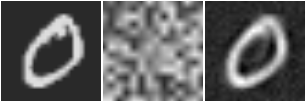

2e couche	


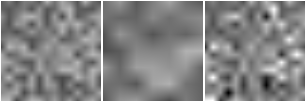

1e couche	


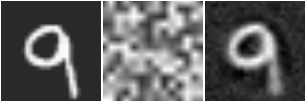

2e couche	


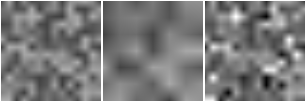

In [15]:
show_autoencoders(1, autoEncoders, Xtrain09, 2)
show_autoencoders(1000, autoEncoders, Xtrain09, 2)

On n'affiche que les résultats pour les 2 premières couches, les autres étant moins pertinentes.


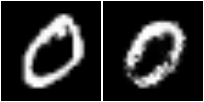

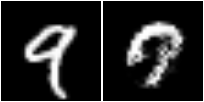

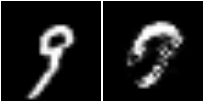

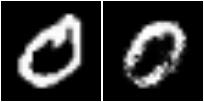

In [16]:
show_decoded(1, autoEncoders, Xtrain09)
show_decoded(2, autoEncoders, Xtrain09)

show_decoded(3, autoEncoders, Xtrain09)
show_decoded(4, autoEncoders, Xtrain09)



On prend l'image originale qu'on code grâce à toutes les fonctions d'encodage. Puis on prend la sortie et on fait l'opération inverse.

Nous n'avons pas optimisé les hyperparamètres de nos autoencodeurs voulant garder la procédure simple et épargner nos microprocesseurs... Il est possible que dans certains cas le modèle soit un peu approximatif.

###Affichage des représentations apprises

4	
1e couche	
196	


2e couche	
49	


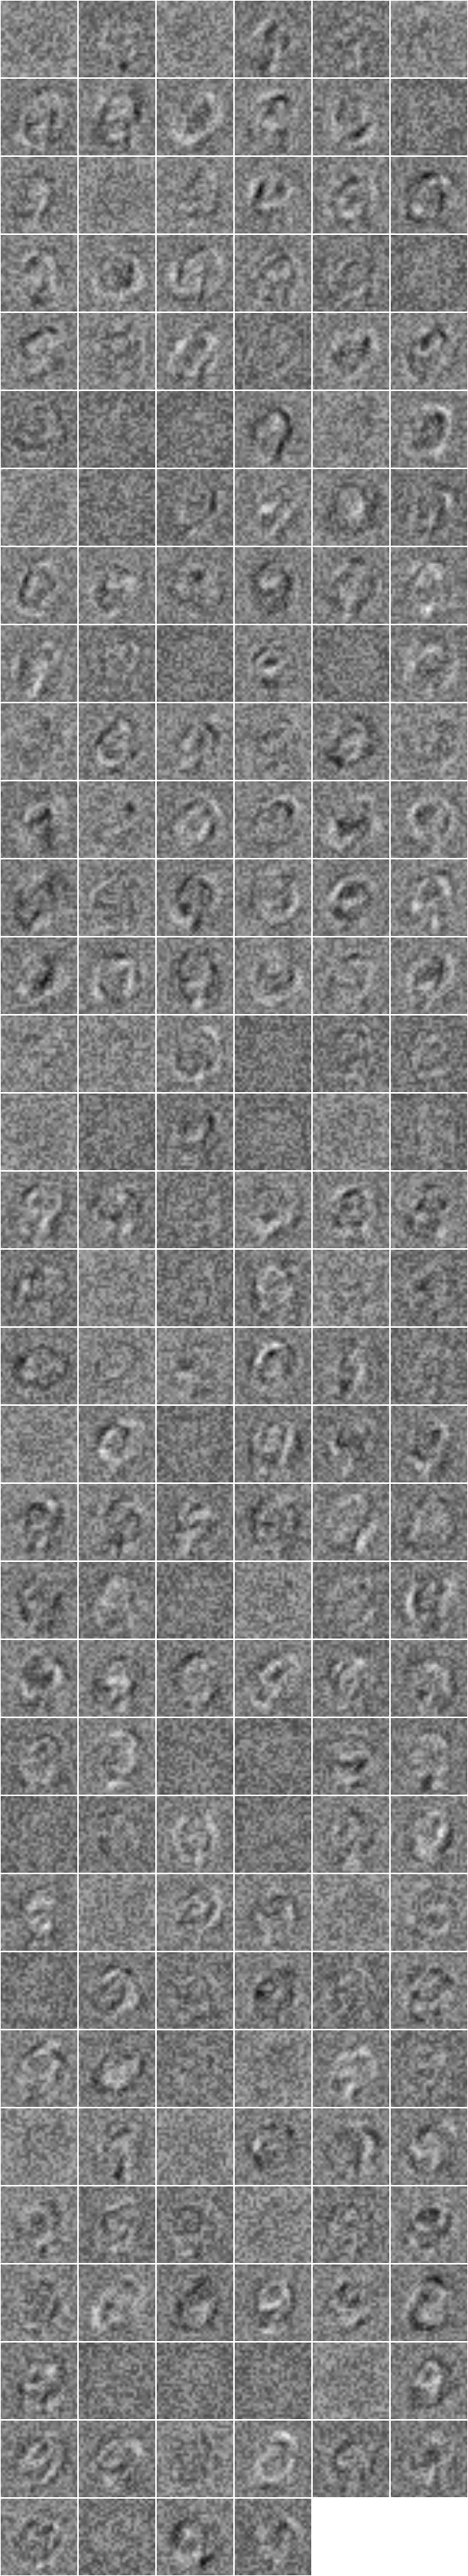

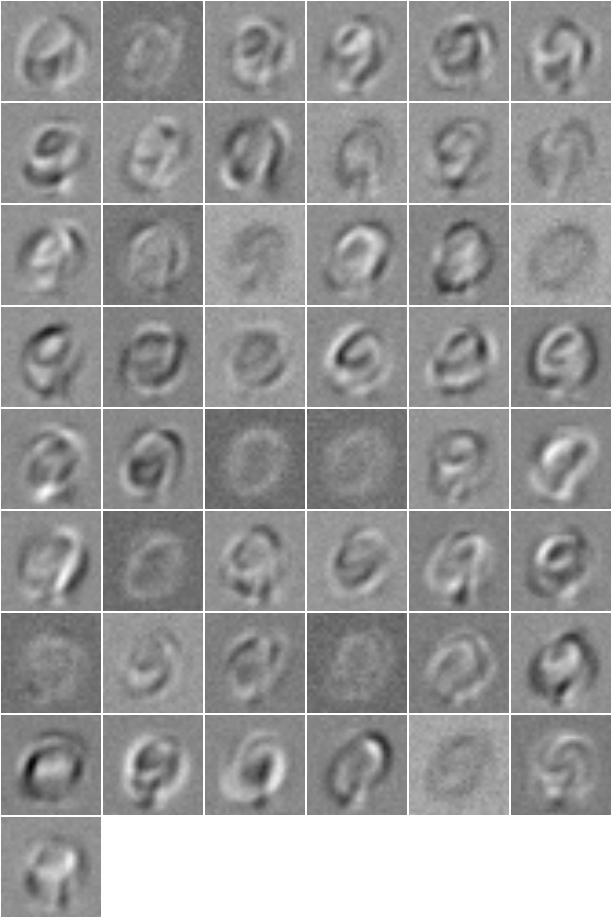

3e couche	
25	


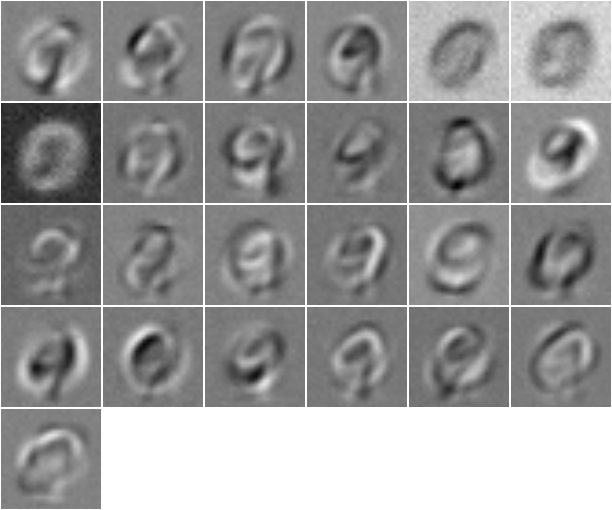

4e couche	
9	


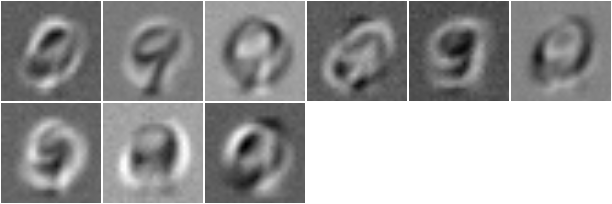

In [17]:
show_representations(autoEncoders, 2)

On voit des choses assez intéressantes grâce à l'affichage des neurones, particulièrement dans les dernières couches, par exemple :
il semble que dans la couche 3, deux neurones codent le fond et le sujet : dans un cas, tout l'espace autour du chiffre est plus lumineux que la moyenne et l'espace central est sombre (peu important) et dans l'autre le contour est plus sombre, et c'est l'espace central qui est lumineux.

Sinon les autres neurones semblent coder les différentes parties de l'image discriminantes entre un 0 et un 9, ce qui semble logique.

###Ajout du classifieur

In [18]:
-- Evaluation
X = moduleFinal:forward(Xtrain09)
y = ytrain09
classif = nn.Linear(X:size(2),2)
criterion = nn.CrossEntropyCriterion() --nn.ClassNLLCriterion()
epsilon = 1e-3
nbiter = X:size()[1]-- * 2
descgrad_stocha(classif, X, y, criterion, epsilon, nbiter)
moduleFinal:add(classif)
moduleFinal:add(nn.LogSoftMax())

pred_probas = moduleFinal:forward(Xtest09)

On stacke un dernièr classifieur linéaire sur nos couches cachées et on donne en sortie proobabilisée grâce au logsoftmax.

###FineTuning + evaluation

In [19]:
criterion = nn.CrossEntropyCriterion() -- nn.ClassNLLCriterion()
epsilon = 1e-3
nbIter = 1000
descgrad_stocha(moduleFinal, Xtrain09, ytrain09, criterion, epsilon, nbiter)
print ("ici")
pred = moduleFinal:forward(Xtest09)
_, pred = torch.max(pred,2)
print("Score après Fine Tuning:")
print(torch.add(ytest09:long(),-pred):eq(0):double():mean())

ici	


Score après Fine Tuning:	
0.9894419306184	


Puis on effectue l'apprentissage des poids de notre dernière couche classifiante (fine tuning).
Les scores ici sont meilleurs que le classifieur linéaire.

Ici on backpropage sur l'ensemble des couches à tous moments.

On peut imaginer que cette opération va "abîmer" nos représentations apprises sur les couches cachées, et donc vouloir dans un premier temps uniquement changer les poids de notre classifieur. On pourrait alors mettre un epsilon plus faible pour les $perc$% itérations sur les backprops pour les couches cachées et garder un espsilon plus grand pour le classifieur à la fin. On pourrait.«

#Classification Multiclasse

##Données

In [20]:
XtrainAll, ytrainAll, XtestAll, ytestAll = getClassTrainTest({0,1,2,3,4,5,6,7,8,9}, trainset, testset)

##Classifieur Linéaire

In [21]:
criterion = nn.CrossEntropyCriterion()
epsilon = 1e-1
nbIter = 1000
local classif_base = nn.Linear(XtrainAll:size(2), 10)
descgrad_stocha(classif_base, XtrainAll, ytrainAll, criterion, epsilon,nbIter)

pred = classif_base:forward(XtestAll)
_, pred = torch.max(pred,2)
print("Score Module Final:")
print(torch.add(ytestAll:long(),-pred):eq(0):double():mean())


##DeepClassifieur

###Création et training des autoencodeurs

In [22]:
modules={}
modules[1]=nn.Linear(28*28, 14*14)
modules[2]=nn.Linear(14*14, 49)
modules[3]=nn.Linear(49, 25)
modules[4]=nn.Linear(25, 9)
autoEncoders = createAutoEncoder(modules)


criterion = nn.MSECriterion()
epsilon = 1e-1
moduleFinal = runAutoEncoders(XtrainAll, autoEncoders, epsilon, criterion)


Score Module Final:	
0.6872	


###Affichage des autoencodeurs
ici on vérifie seulement l'état des 2 premièrs autoencodeurs.

1e couche	


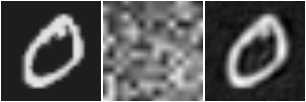

2e couche	


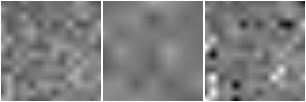

1e couche	


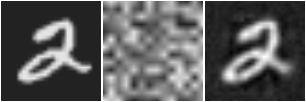

2e couche	


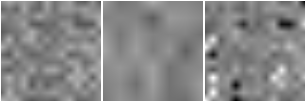

1e couche	


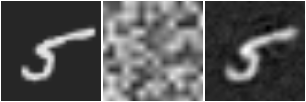

2e couche	


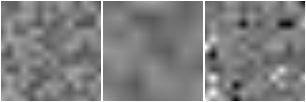

1e couche	


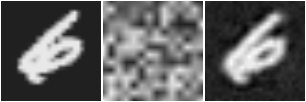

2e couche	


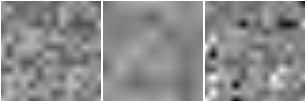

In [23]:
show_autoencoders(2, autoEncoders, XtrainAll, 2)
show_autoencoders(6, autoEncoders, XtrainAll, 2)
show_autoencoders(66, autoEncoders, XtrainAll, 2)
show_autoencoders(666, autoEncoders, XtrainAll, 2)

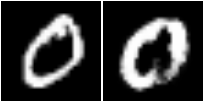

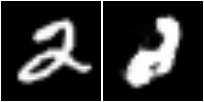

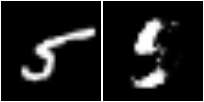

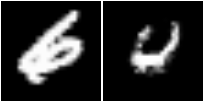

In [28]:
show_decoded(2, autoEncoders, XtrainAll)
show_decoded(6, autoEncoders, XtrainAll)
show_decoded(66, autoEncoders, XtrainAll)
show_decoded(666, autoEncoders, XtrainAll)

4	
1e couche	
196	


2e couche	
49	


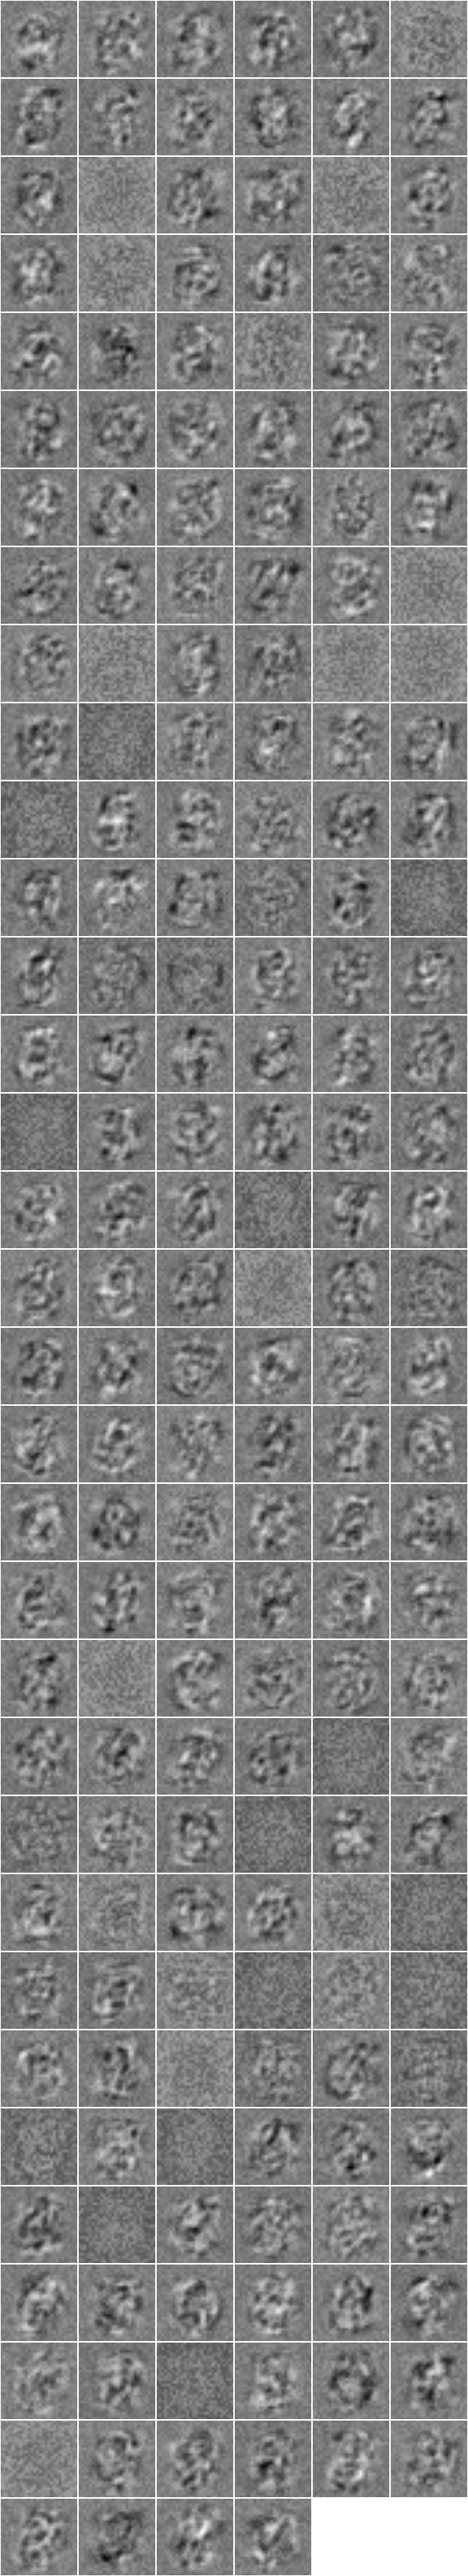

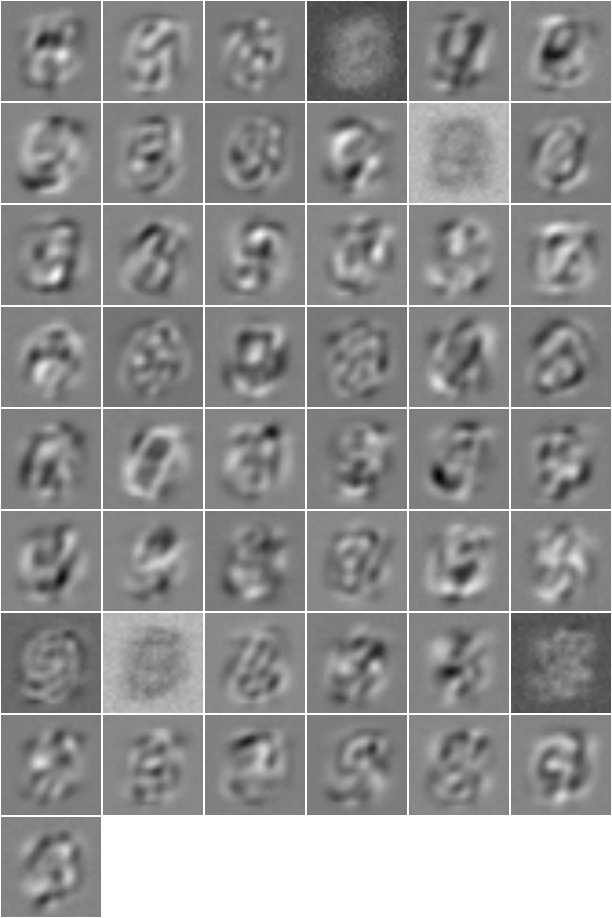

3e couche	
25	


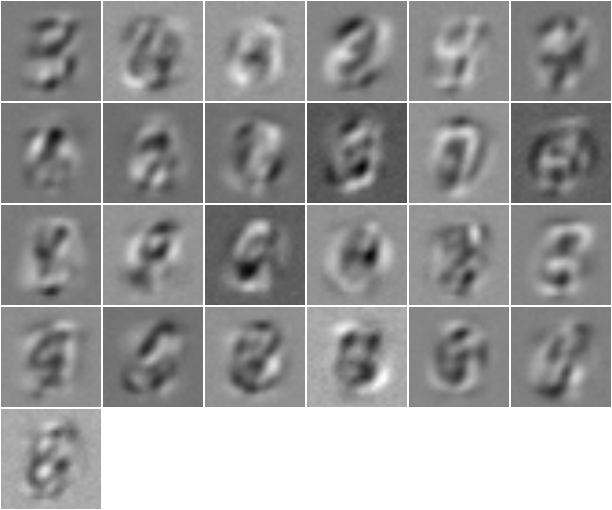

4e couche	
9	


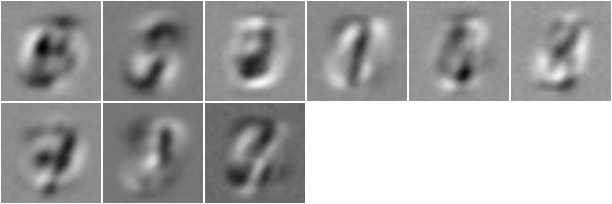

In [25]:
show_representations(autoEncoders, 2)

Ici de la même manière que dans le classifieur bi-classe, on voit que certain neurones portent une information générale (fond, sujet) et d'autres une information purement discriminante : différence entre un 1 et un 4 par exemple etc...

###Ajout du classifieur

In [26]:
X = moduleFinal:forward(XtrainAll)
y = ytrainAll
classif = nn.Linear(X:size(2),10)
criterion = nn.CrossEntropyCriterion() --nn.ClassNLLCriterion()
epsilon = 1e-3
nbiter = X:size()[1]-- * 2
descgrad_stocha(classif, X, y, criterion, epsilon, nbiter)
moduleFinal:add(classif)
moduleFinal:add(nn.LogSoftMax())

pred_probas = moduleFinal:forward(XtestAll)

###FineTuning + evaluation

In [27]:
--FineTuning + evaluation

criterion = nn.CrossEntropyCriterion() -- nn.ClassNLLCriterion()
epsilon = 1e-3
nbIter = 1000
descgrad_stocha(moduleFinal, XtrainAll, ytrainAll, criterion, epsilon, nbiter)
pred = moduleFinal:forward(XtestAll)
_, pred = torch.max(pred,2)
print("Score après Fine Tuning:")
print(torch.add(ytestAll:long(),-pred):eq(0):double():mean())

Score après Fine Tuning:	
0.9008	


Ici l'interêt d'avoir plusieurs couches est manifeste avec un gain de performances de plus de 20%.

#Conclusion

Les features apprises sont intéressantes et montrent que le système se concentre sur l'apprentissage d'informations discriminantes. 
Nos modèles n'ont pas fait l'objet d'une rechercher de paramètres poussée mais nous obtenons tout de même de bons scores.

Pour une tâche simple telle que de la classification bi-classe, il n'y a à l'évidence pas d'interêt à utiliser du deep learning, mais dans le cas de tâches plus complexes, l'utilisation de cette technique permet d'augmenter considérablement les performances ainsi que de dégager de la connaissance grâce aux features apprises sur les couches de faible dimension en particulier.

Il serait intéressant de tester ce modèle sur des données plus complexes ou bruitées que MNIST pour observer le comportement du modèle. 

On pourrait aussi afficher les nouvelles représentations apprises après ajout du classifieur. On suppose que cela permettrait d'extraire des features plus intéressantes et discriminantes qu'un autoencodeur simple qui minimise l'erreur des moindres carrés.